In [2]:
import pandas as pd
import numpy as np
import os
import os.path as op
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
datadir = "/data/RocklandSample/assessments/"
files = sorted([op.join(datadir, f) for f in os.listdir(datadir) if f.endswith('csv')])
files

['/data/RocklandSample/assessments/3760_Age_20140917.csv',
 '/data/RocklandSample/assessments/3760_HT_WT_Vitals_20140917.csv',
 '/data/RocklandSample/assessments/3760_MRI_Log_Sheet_20140917.csv',
 '/data/RocklandSample/assessments/data-2020-02-27T19_53_11.485Z.csv',
 '/data/RocklandSample/assessments/scan_visit_list.csv',
 '/data/RocklandSample/assessments/subjects_sessions_to_process.csv']

In [5]:
age_df = pd.read_csv(files[0])
htwt_df = pd.read_csv(files[1])
log_df = pd.read_csv(files[2])
visits_df = pd.read_csv(files[4])

In [6]:
multi_df = pd.DataFrame(columns=["Anonymized ID", "Study Codes", "Visit Codes", "DWI and T1w"])
count = 0
for aid in visits_df['Anonymized ID'].unique():
    tmpdf = visits_df.loc[visits_df['Anonymized ID'] == aid] 
    if len(tmpdf) > 1:
        ims = [tmpdf["DWI"].unique, tmpdf["T1w"].unique]
        multi_df = multi_df.append({"Anonymized ID": aid,
                                    "Study Codes": tmpdf["Study Code"].unique(),
                                    "Visit Codes": tmpdf["Visit Code"].unique(),
                                    "DWI and T1w": all(ims)}, ignore_index=True)
        count += 1
print(count)

290


In [7]:
multi_df

,Anonymized ID,Study Codes,Visit Codes,DWI and T1w
0,A00018030,"[CLG, DS]","[4, 4R, 2]",True
1,A00027159,"[CLG, DS]","[4, 4R, 2]",True
2,A00027167,"[CLG, DS]","[4, 4R, 2]",True
3,A00027439,"[CLG, DS]","[4, 4R, 2]",True
4,A00028185,"[DS, NFB]","[2, 2R, 3]",True
...,...,...,...,...
285,A00066860,"[CLG, DS]","[2R, A]",True
286,A00066926,[NFB],"[3, A]",True
287,A00072203,[NFB],"[3, A]",True
288,A00073600,[NFB],"[3, A]",True


In [8]:
filehandle = "/data/RocklandSample/dmriprep_filelist.txt"
with open(filehandle, 'r') as fhandle:
    data = fhandle.readlines()

In [9]:
columns = ["subject", "dataset", "n_sessions",  "data"]
df = pd.DataFrame(columns=columns)

lut = {"aparc+aseg.nii.gz": 0,
       "T1w.nii.gz": 1,
       "dwi.bvals": 2,
       "dwi.bvecs": 3,
       "dwi.nii.gz": 4}
del tmpdf
for line in data:
    l = line.strip()
    issub = l.startswith("sub-") and not l.endswith("gz") and not l.endswith("s")

    if issub:
        # if there's a previous subj DF, add it to the stack
        try:
            df = df.append(tmpdf, ignore_index=True, sort=False)
            del tmpdf
        except NameError as e:
            pass

        # create new subj DF
        sub = l.strip('sub-')
        tmpdf = {"subject": sub,
                 "dataset": [],
                 "n_sessions": 0,
                 "data": [   0,    0,    0,    0,    0]}
                #        aparc,   t1, bval, bvec,  dwi 
        continue

    isses = l.startswith("ses-")
    if isses:
        ses = l.strip('ses-')
        tmpdf["dataset"] += [ses]
        tmpdf["n_sessions"] += 1
        continue

    if l == "anat" or l == "dwi" or l is '':
        continue

    ending = l.split("_")[-1]
    tmpdf["data"][lut[ending]] += 1
df

,subject,dataset,n_sessions,data
0,A00008326,[DS2],1,"[1, 1, 1, 1, 1]"
1,A00010893,[DS2],1,"[1, 1, 1, 1, 1]"
2,A00013809,[DS2],1,"[0, 1, 1, 1, 1]"
3,A00018030,"[CLG4, CLG4R, DS2]",3,"[3, 3, 3, 3, 3]"
4,A00019903,[DS2],1,"[1, 1, 1, 1, 1]"
...,...,...,...,...
887,A00073677,[ALGA],1,"[1, 1, 1, 1, 1]"
888,A00073705,[DSA],1,"[1, 1, 1, 1, 1]"
889,A00073942,[ALGA],1,"[1, 1, 1, 1, 1]"
890,A00073953,[ALGA],1,"[1, 1, 1, 1, 1]"


In [10]:
nki_loris = pd.read_csv("/data/RocklandSample/assessments/data-2020-02-27T19_53_11.485Z.csv")
nki_loris

,Identifiers,calculated_age,age,sex,studies,ht_cm,wt_kg,bmi,pulse
0,A00008326,59.33698630136999,59.0,2,Discovery,160.02,66.68,26.040364501994,74
1,A00008326,64.547945205479,64.0,2,Longitudinal_Adult,159.1,72.7,28.720635915175,65
2,A00008326,65.613698630137,65.0,2,Longitudinal_Adult,159,71.6,28.32166449112,62
3,A00008326,66.56712328767101,66.0,2,Longitudinal_Adult,159,70.3,27.807444325778,64
4,A00008399,23.389041095889997,23.0,1,Discovery,172.72,91.63,30.715134959682,68
...,...,...,...,...,...,...,...,...,...
2441,A00084876,.,61.0,1,Longitudinal_Adult,179,104.8,32.708092756156,71
2442,A00085188,.,70.0,2,Longitudinal_Adult,160,64.4,25.15625,70
2443,A00086597,.,44.0,2,Longitudinal_Adult,171,128.4,43.910946958038,60
2444,A00086598,.,7.0,1,Longitudinal_Child,139,46.3,23.96356296258,66


In [11]:
merged_df = []

for idx, row in df.iterrows():
    tmpdf = {}
    idd = row['subject']
    for col, val in zip(df.columns, row.values):
        tmpdf[col] = val
    
    relev_rows = nki_loris[nki_loris["Identifiers"] == idd]
    cols = nki_loris.columns
    cols = cols.drop('Identifiers').drop('studies')
    for col in cols:
        tmpdf[col] = list(relev_rows[col].values)

    if len(tmpdf["age"]) > 0 and len(tmpdf["bmi"]) > 0 and len(tmpdf["sex"]) > 0:
        merged_df += [tmpdf]

merged_df = pd.DataFrame(merged_df)
merged_df

,subject,dataset,n_sessions,data,calculated_age,age,sex,ht_cm,wt_kg,bmi,pulse
0,A00008326,[DS2],1,"[1, 1, 1, 1, 1]","[59.33698630136999, 64.547945205479, 65.613698...","[59.0, 64.0, 65.0, 66.0]","[2, 2, 2, 2]","[160.02, 159.1, 159, 159]","[66.68, 72.7, 71.6, 70.3]","[26.040364501994, 28.720635915175, 28.32166449...","[74, 65, 62, 64]"
1,A00010893,[DS2],1,"[1, 1, 1, 1, 1]",[28.909589041096],[28.0],[1],[170.18],[66.22],[22.8650490716],[60]
2,A00013809,[DS2],1,"[0, 1, 1, 1, 1]",[61.956164383562005],[61.0],[2],[162.6],[51.36],[19.426024518548],[56]
3,A00018030,"[CLG4, CLG4R, DS2]",3,"[3, 3, 3, 3, 3]","[11.67397260274, 13.545205479452]","[11.0, 13.0]","[2, 2]","[144.78, 157.5]","[32.66, 44.45]","[15.581133039767, 17.918871252205]","[54, 72]"
4,A00019903,[DS2],1,"[1, 1, 1, 1, 1]",[83.183561643836],[83.0],[1],[177.8],[71.21],[22.525657296213],[70]
...,...,...,...,...,...,...,...,...,...,...,...
884,A00073677,[ALGA],1,"[1, 1, 1, 1, 1]","[44.93698630137, 46.030136986301, 46.912328767...","[44.0, 46.0, 46.0, 47.0]","[2, 2, 2, 2]","[168, 168, 168.3, 169.2]","[90.7, 92.5, 91.6, 92.1]","[32.135770975057, 32.773526077098, 32.33904880...","[70, 76, 72, 64]"
885,A00073705,[DSA],1,"[1, 1, 1, 1, 1]",[78.51232876712301],[78.0],[2],[167],[58.1],[20.832586324357],[66]
886,A00073942,[ALGA],1,"[1, 1, 1, 1, 1]","[62.194520547945004, 63.167123287671004, 64.05...","[62.0, 63.0, 64.0, 65.0]","[2, 2, 2, 2]","[155, 156, 153, 155.1]","[78.5, 76.8, 75.7, 75.3]","[32.67429760666, 31.558185404339, 32.337989662...","[66, 81, 72, 91]"
887,A00073953,[ALGA],1,"[1, 1, 1, 1, 1]","[69.024657534247, 70.180821917808, 71.07397260...","[69.0, 70.0, 71.0]","[2, 2, 2]","[164, 166, 167]","[96, 95.7, 96.6]","[35.693039857228, 34.729278560023, 34.63731220...","[72, 64, 60]"


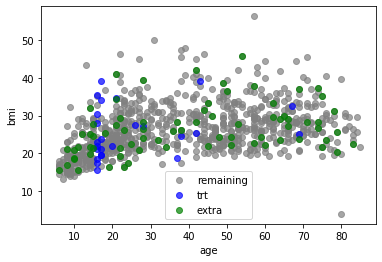

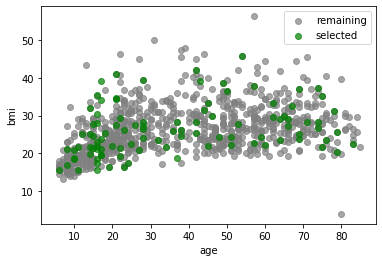

In [93]:

ages = np.array([v[0] for v in merged_df.age.values])
bmis = np.array([float(v[0]) for v in merged_df.bmi.values])
zexes = np.array([int(v[0]) for v in merged_df.sex.values])

trt_set = [_
           for _, v in merged_df.iterrows()
           if v.n_sessions > 1 and v.age[0] >= 16]
extra_set = merged_df.drop(index=trt_set, inplace=False).sample(n=75, random_state=45).index

remaining_set = merged_df.loc[~merged_df.index.isin(trt_set)].index

# merged_df.loc[~merged_df.index.isin(trt_set)]
# extra_set = np.array([merged_df.sample])
a = 0.7
plot = plt.scatter(ages[remaining_set], bmis[remaining_set], alpha=a, c='gray')
plot = plt.scatter(ages[trt_set], bmis[trt_set], alpha=a, c='blue')
plot = plt.scatter(ages[extra_set], bmis[extra_set], alpha=a, c='green')
plt.xlabel("age")
plt.ylabel("bmi")
plt.legend(["remaining", "trt", "extra"])
plt.show()

used_set = trt_set + list(extra_set)
plot = plt.scatter(ages[remaining_set], bmis[remaining_set], alpha=a, c='gray')
plot = plt.scatter(ages[used_set], bmis[used_set], alpha=a, c='green')
plt.xlabel("age")
plt.ylabel("bmi")
plt.legend(["remaining", "selected"])
plt.show()

In [97]:
print("subset__ BMI overweight (healthy): {0} ({1})".format(sum(bmis[used_set] >= 25), sum(bmis[used_set] < 25)))
print("subset__ Age quantiles: {0}".format(np.percentile(ages[used_set], [0, 20, 40, 60, 80, 99])))
print("subset__ Portion female (male): {0} ({1})".format(sum(zexes[used_set]>1), sum(zexes[used_set]<=1)))

subset__ BMI overweight (healthy): 52 (48)
subset__ Age quantiles: [ 6.   16.   22.   42.   62.4  79.04]
subset__ Portion female (male): 60 (40)


In [99]:
print("full__ BMI overweight (healthy): {0} ({1})".format(sum(bmis >= 25), sum(bmis < 25)))
print("full__ Age quantiles: {0}".format(np.percentile(ages, [0, 20, 40, 60, 80, 99])))
print("full__ Portion female (male): {0} ({1})".format(sum(zexes>1), sum(zexes<=1)))

full__ BMI overweight (healthy): 476 (413)
full__ Age quantiles: [ 6.   16.   25.2  45.   60.   81.12]
full__ Portion female (male): 541 (348)


In [89]:
experiment_df = merged_df.loc[used_set]
experiment_df.to_csv('/data/RocklandSample/selected_participants.csv', index=False)

In [151]:
len(merged_df.loc[~merged_df.index.isin(trt_set)]), len(merged_df), len(trt_set)

(864, 889, 25)

In [59]:
trt_df = merged_df.copy()

single_sessions = trt_df[trt_df["n_sessions"] < 2].index
trt_df.drop(single_sessions, inplace=True)

missing_data = trt_df[trt_df["data"].map(sum) < 5*trt_df["n_sessions"]].index
trt_df.drop(missing_data, inplace=True)

# ds = lambda x: "DS2" not in x and "DSA" not in x
# only_x_sectional = trt_df[multi_df["dataset"].map(ds)].index
# trt_df.drop(only_x_sectional, inplace=True)

trt_df.reset_index(inplace=True, drop=True)

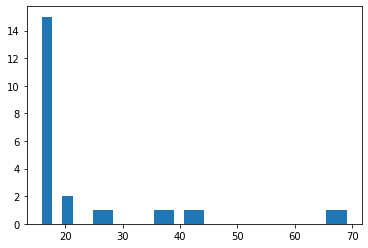

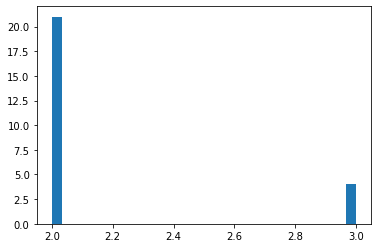

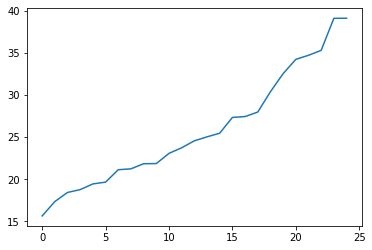

In [110]:
age_rows = [row for idx, row in trt_df.iterrows() if row.age[0] >= 16]
ages = np.array([r.age[0] for r in age_rows])
bmis = np.array([float(r.bmi[0]) for r in age_rows])
sess = np.array([r.n_sessions for r in age_rows])

plot = plt.hist(ages, bins=30)
plt.show()

plot = plt.plot(sorted(bmis))
plt.show()

In [100]:
ages

array([37., 21., 16., 28., 26., 20., 16., 17., 16., 16., 17., 42., 38.,
       43., 69., 16., 16., 67., 16., 17., 16., 17., 16., 17., 17.])

In [78]:
len(ages[ages > 18])

668

In [88]:
merged_df

,subject,dataset,n_sessions,data,calculated_age,age,sex,ht_cm,wt_kg,bmi,pulse
0,A00008326,[DS2],1,"[1, 1, 1, 1, 1]","[59.33698630136999, 64.547945205479, 65.613698...","[59.0, 64.0, 65.0, 66.0]","[2, 2, 2, 2]","[160.02, 159.1, 159, 159]","[66.68, 72.7, 71.6, 70.3]","[26.040364501994, 28.720635915175, 28.32166449...","[74, 65, 62, 64]"
1,A00010893,[DS2],1,"[1, 1, 1, 1, 1]",[28.909589041096],[28.0],[1],[170.18],[66.22],[22.8650490716],[60]
2,A00013809,[DS2],1,"[0, 1, 1, 1, 1]",[61.956164383562005],[61.0],[2],[162.6],[51.36],[19.426024518548],[56]
3,A00018030,"[CLG4, CLG4R, DS2]",3,"[3, 3, 3, 3, 3]","[11.67397260274, 13.545205479452]","[11.0, 13.0]","[2, 2]","[144.78, 157.5]","[32.66, 44.45]","[15.581133039767, 17.918871252205]","[54, 72]"
4,A00019903,[DS2],1,"[1, 1, 1, 1, 1]",[83.183561643836],[83.0],[1],[177.8],[71.21],[22.525657296213],[70]
...,...,...,...,...,...,...,...,...,...,...,...
884,A00073677,[ALGA],1,"[1, 1, 1, 1, 1]","[44.93698630137, 46.030136986301, 46.912328767...","[44.0, 46.0, 46.0, 47.0]","[2, 2, 2, 2]","[168, 168, 168.3, 169.2]","[90.7, 92.5, 91.6, 92.1]","[32.135770975057, 32.773526077098, 32.33904880...","[70, 76, 72, 64]"
885,A00073705,[DSA],1,"[1, 1, 1, 1, 1]",[78.51232876712301],[78.0],[2],[167],[58.1],[20.832586324357],[66]
886,A00073942,[ALGA],1,"[1, 1, 1, 1, 1]","[62.194520547945004, 63.167123287671004, 64.05...","[62.0, 63.0, 64.0, 65.0]","[2, 2, 2, 2]","[155, 156, 153, 155.1]","[78.5, 76.8, 75.7, 75.3]","[32.67429760666, 31.558185404339, 32.337989662...","[66, 81, 72, 91]"
887,A00073953,[ALGA],1,"[1, 1, 1, 1, 1]","[69.024657534247, 70.180821917808, 71.07397260...","[69.0, 70.0, 71.0]","[2, 2, 2]","[164, 166, 167]","[96, 95.7, 96.6]","[35.693039857228, 34.729278560023, 34.63731220...","[72, 64, 60]"


In [24]:
multi_df = df.copy()

single_sessions = multi_df[multi_df["n_sessions"] < 2].index
multi_df.drop(single_sessions, inplace=True)

missing_data = multi_df[multi_df["data"].map(sum) < 5*multi_df["n_sessions"]].index
multi_df.drop(missing_data, inplace=True)

ds = lambda x: "DS2" not in x and "DSA" not in x
only_x_sectional = multi_df[multi_df["dataset"].map(ds)].index
multi_df.drop(only_x_sectional, inplace=True)

multi_df.reset_index(inplace=True, drop=True)

In [107]:
flatten = [f for l in newdf.dataset.values for f in l]
[(x, flatten.count(x)) for x in set(flatten)]

[('NFBAR', 3),
 ('NFB2R', 1),
 ('ALGA', 5),
 ('DSA', 10),
 ('CLG4', 35),
 ('CLG5', 7),
 ('CLG2R', 83),
 ('NFB2', 4),
 ('CLGA', 16),
 ('CLG4R', 14),
 ('CLG2', 46),
 ('DS2', 32)]

In [112]:
flatten = [f[:3] for l in df.dataset.values for f in l]
[(x, flatten.count(x)) for x in set(flatten)]

[('DSA', 133), ('NFB', 102), ('ALG', 23), ('DS2', 538), ('CLG', 265)]